In [9]:
%%time

import pandas as pd, numpy as np

%load_ext autoreload
%autoreload 2

def vc_method(self):
    return self.value_counts(dropna=False, normalize=True)
pd.Series.vc = vc_method

from init_data import init_data

first_time_launch = False
if first_time_launch:
    init_data()

X = pd.read_parquet('train.parquet')

n_val = int(0.23 * X.shape[0])
X_tr, X_val = X.iloc[:-n_val].reset_index(drop=True), \
                X.iloc[-n_val:].reset_index(drop=True)
    
features = X.columns.drop(['is_callcenter', 'model_create_time', 'create_time'])

X_tr[features].info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54829 entries, 0 to 54828
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            54829 non-null  int64  
 1   good_id             54829 non-null  int64  
 2   price               54829 non-null  int64  
 3   utm_medium          54829 non-null  int64  
 4   utm_source          48653 non-null  float64
 5   sessionkey_id       54829 non-null  int64  
 6   category_id         54829 non-null  int64  
 7   parent_id           54829 non-null  int64  
 8   root_id             54829 non-null  int64  
 9   model_id            54829 non-null  int64  
 10  is_moderated        54829 non-null  int64  
 11  rating_value        17582 non-null  float64
 12  rating_count        27012 non-null  float64
 13  description_length  54829 non-null  int64  
 14  goods_qty     

In [21]:
import lightgbm as lgb

tr_data = lgb.Dataset(X_tr[features], X_tr.is_callcenter, free_raw_data=False)
val_data = lgb.Dataset(X_val[features], X_val.is_callcenter, free_raw_data=False)

init_params = {
    'seed': 911,
    'nthread': 16,
    'verbose': -1,
    
    'eta': 0.1,
    'boost_from_average': False, # не работает на кастомных лоссах
    'is_unbalance': False, # не работает на кастомных лоссах
    'scale_pos_weight': 1, # не работает на кастомных лоссах
    
    'objective': 'binary',
    'metric': '' # мерить objective на valid_sets
}

model_kwargs = {
    'train_set': tr_data,
    'valid_sets': [val_data],
    'valid_names': ['val'],
    'num_boost_round': 140,
    'callbacks': [lgb.log_evaluation(period=20)]
}

# Кастомные лоссы

**Зачем?**
- асимметричная метрика
- лосс, которого нет в библиотеке
- хитрый учет весов
- лучшее соответствие метрике
- ...

## Уровень 0. LogLoss

### 1. написанный за вас

In [22]:
model = lgb.train(params, **model_kwargs)

[20]	val's binary_logloss: 0.184704
[40]	val's binary_logloss: 0.15298
[60]	val's binary_logloss: 0.162947
[80]	val's binary_logloss: 0.164382
[100]	val's binary_logloss: 0.163659
[120]	val's binary_logloss: 0.169898
[140]	val's binary_logloss: 0.171673


### 2. напишем сами
    
#### 2.1. feval


$$ LogLoss = - y_i \cdot ln(p_i) - (1 - y_i) \cdot ln(1 - p_i) $$
    

$$ p_i = \frac{1}{1 + e^{-y_{raw_i}}} $$

In [23]:
from scipy.special import expit

def custom_log_loss(y_raw, tr_data=None, y_true=None, is_custom_objective=False):
    '''
    y_raw - raw scores если fobj is not None. Иначе - expit(raw)
    tr_data: lgb.Dataset - train
    
     - веса пока не учитываем
    '''
    # это для того чтобы работать с этой функцией из ноутбука
    if y_true is None:
        y_true = tr_data.get_label()
    y_prob = expit(y_raw) if is_custom_objective else y_raw
    
    loss = np.zeros(y_prob.shape[0])
    cond = y_true == 0
    loss[cond] = - np.log(1 - y_prob[cond])
    cond = y_true == 1
    loss[cond] = - np.log(y_prob[cond])
    
            # name,          feval_value,   greater_is_better
    return 'custom_log_loss', loss.mean(), False

model = lgb.train(init_params, feval=custom_log_loss, **model_kwargs)

[20]	val's binary_logloss: 0.184704	val's custom_log_loss: 0.184704
[40]	val's binary_logloss: 0.15298	val's custom_log_loss: 0.15298
[60]	val's binary_logloss: 0.162947	val's custom_log_loss: 0.162947
[80]	val's binary_logloss: 0.164382	val's custom_log_loss: 0.164382
[100]	val's binary_logloss: 0.163659	val's custom_log_loss: 0.163659
[120]	val's binary_logloss: 0.169898	val's custom_log_loss: 0.169898
[140]	val's binary_logloss: 0.171673	val's custom_log_loss: 0.171673


#### 2.2 fobj

In [ ]:
L

In [29]:
def custom_log_loss_grad_hess(y_raw, tr_data=None, y_true=None):
    '''
    gi, hi считаются по w=y_raw, а не по p=expit(raw)
    - веса пока не учитываем
    '''
    if y_true is None:
        y_true = tr_data.get_label()
    y_prob = expit(y_raw)
    
    w = tr_data.get_weight() # VESA
    grad = y_prob - y_true
    hess = y_prob * (1 - y_prob)
    
    return grad, hess



from functools import partial

params = init_params.copy()
params['objective'] = custom_log_loss_grad_hess

model = lgb.train(
    params,
    feval=partial(custom_log_loss, is_custom_objective=True), # is_custom_objective=True - нужно, когда меняем objective 
#     fobj=custom_log_loss_grad_hess, # Old style
    **model_kwargs
)

[LightGBM] [Info] Using self-defined objective function
[20]	val's custom_log_loss: 0.184704
[40]	val's custom_log_loss: 0.15298
[60]	val's custom_log_loss: 0.162947
[80]	val's custom_log_loss: 0.164382
[100]	val's custom_log_loss: 0.163659
[120]	val's custom_log_loss: 0.169898
[140]	val's custom_log_loss: 0.171673


## Уровень 1. LogLoss transformations

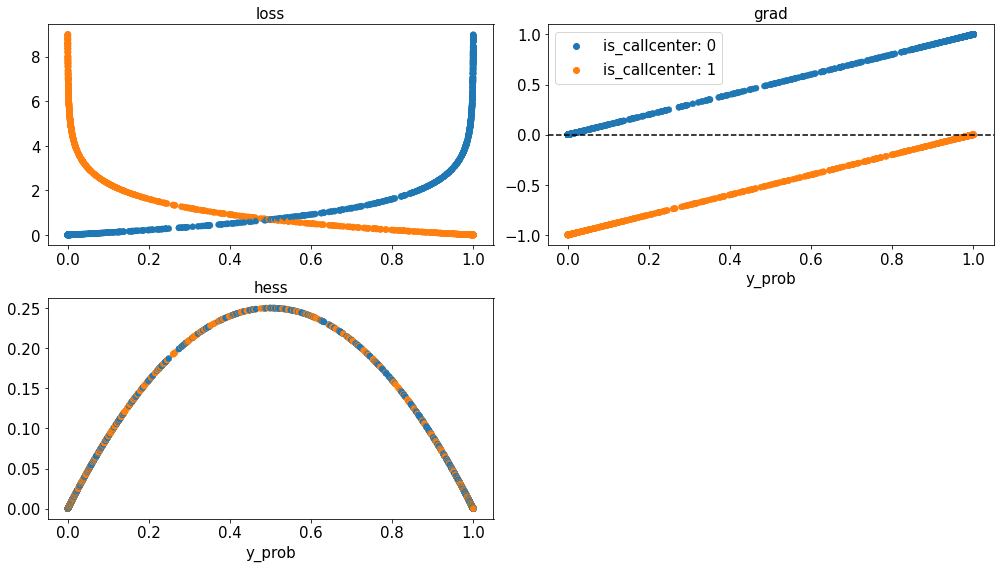

In [8]:
from seminar_utils import plot_loss_grad_hess

def custom_log_loss_on_object(y_raw, y_true):
    '''
    y_raw - raw scores
    лосс "на одном объекте", а не средний
    
    возвращает вектор с пообъектным лоссом для каждого y_prob_i, y_true_i
    '''
    if y_true is None:
        y_true = tr_data.get_label()
    y_prob = expit(y_raw)
    
    loss = np.zeros(y_prob.shape[0])
    cond = y_true == 0
    loss[cond] = - np.log(1 - y_prob[cond])
    cond = y_true == 1
    loss[cond] = - np.log(y_prob[cond])
    
    return loss

plot_loss_grad_hess(feval=custom_log_loss_on_object, fobj=custom_log_loss_grad_hess)

Напоминание:
<font size=5>
$$ w_i  = - \frac{\sum g_i}{\sum h_i + \lambda} $$

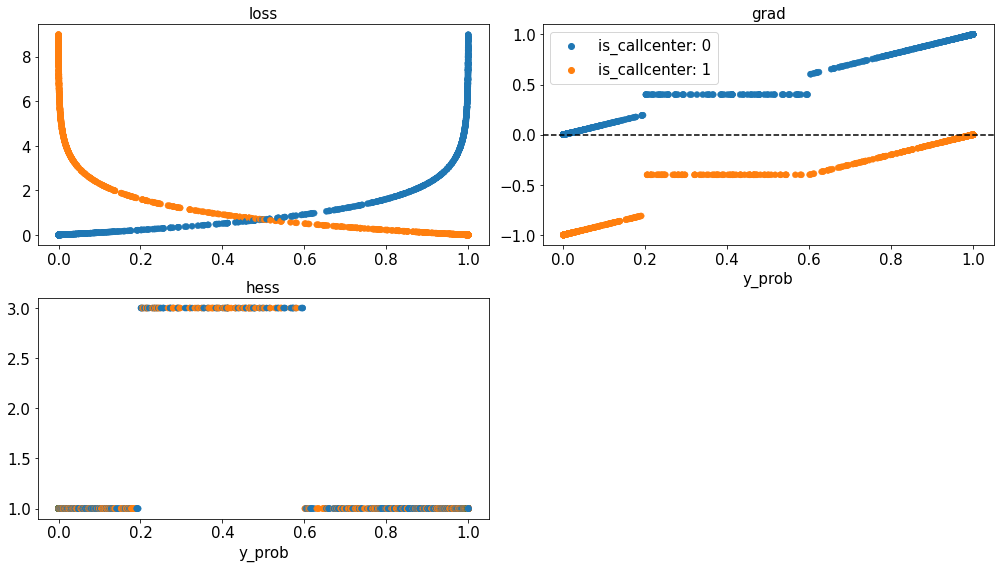

In [9]:
# gi - направления, 1/hi - мера неуверенности в gi

def custom_log_loss_grad_hess_transformed(y_raw, tr_data=None, y_true=None, grey_zone=(0.2, 0.6)):
    '''
    - веса пока не учитываем
    '''
    if y_true is None:
        y_true = tr_data.get_label()
    y_prob = expit(y_raw)
    
    grad = y_prob - y_true
    cond = (grey_zone[0] < y_prob) & (y_prob < grey_zone[1])
    grad[cond] = (1 - 2 * y_true[cond]) * (grey_zone[0] + grey_zone[1]) / 2
    
    hess = y_prob * (1 - y_prob)
    hess[cond] = 3
    hess[~cond] = 1 
    
    return grad, hess

plot_loss_grad_hess(feval=custom_log_loss_on_object, fobj=custom_log_loss_grad_hess_transformed)

***Было:***

init prediction range: -9.712770998373344 8.749641370506994
after expit: 0.0001 0.9998

ROC AUC on val: 0.9683


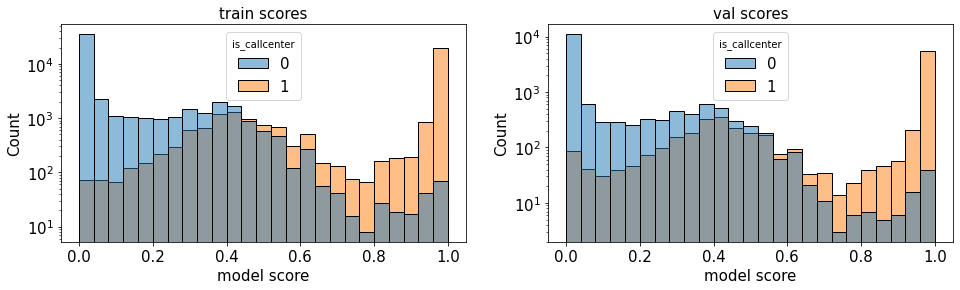

In [10]:
params = dict()
params.update(init_params)

model = lgb.train(
    params,
    feval=partial(custom_log_loss, is_custom_objective=True),
    fobj=custom_log_loss_grad_hess, # <---
    **new_model_kwargs,
)

look_at_scores(model)

***Стало:***

init prediction range: -7.366895930541075 9.466826564682332
after expit: 0.0006 0.9999

ROC AUC on val: 0.9642


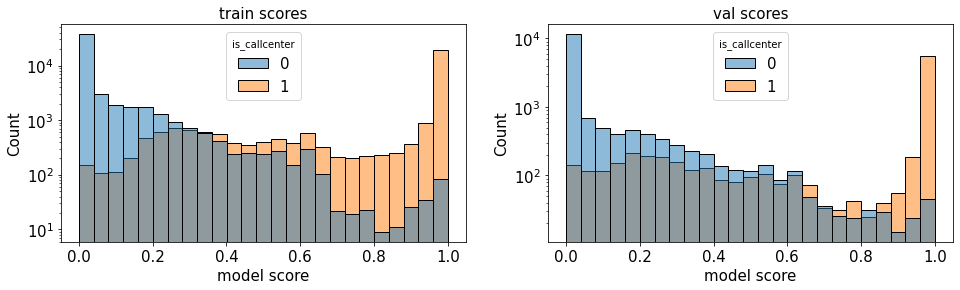

In [11]:
params = dict()
params.update(init_params)
params.update({
    'eta': 5
})

model = lgb.train(
    params,
    feval=partial(custom_log_loss, is_custom_objective=True),
    fobj=custom_log_loss_grad_hess_transformed, # <----
    **new_model_kwargs,
)

look_at_scores(model)

***Вывод:*** выглядит `как-то по-другому`

Распределение "вероятностей" может быть обманчиво, поэтому лучше смотреть на голые скоры:

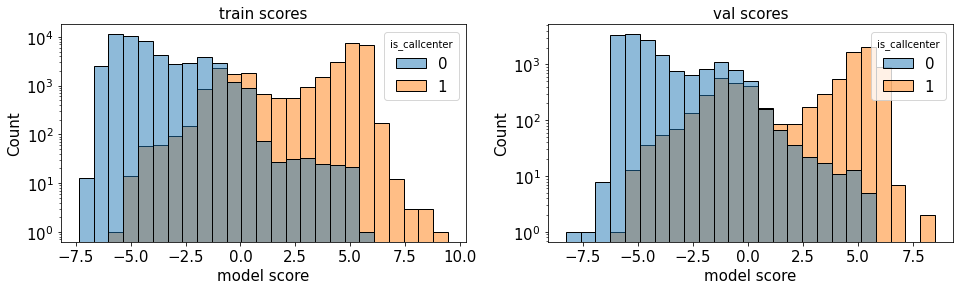

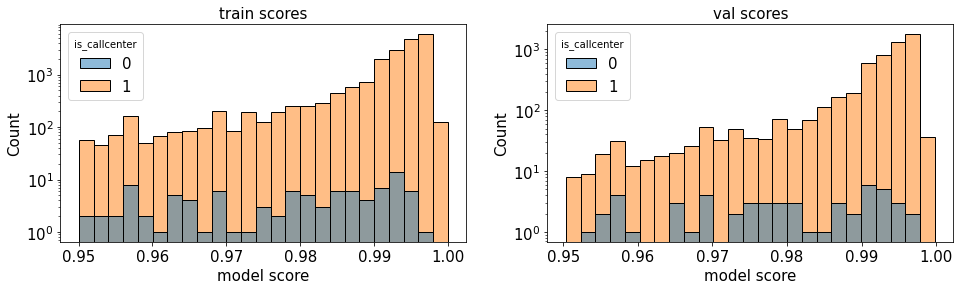

In [12]:
look_at_scores(model, raw=True, info=False)
look_at_scores(model, x_right=0.95, info=False)

## Уровень 2. Сооружаем свой loss

Training until validation scores don't improve for 100 rounds
[20]	train's fbeta: 0.917312	val's fbeta: 0.91762
[40]	train's fbeta: 0.918326	val's fbeta: 0.918209
[60]	train's fbeta: 0.919184	val's fbeta: 0.918419
[80]	train's fbeta: 0.919611	val's fbeta: 0.918554
[100]	train's fbeta: 0.92018	val's fbeta: 0.918763
[120]	train's fbeta: 0.920709	val's fbeta: 0.918856
[140]	train's fbeta: 0.921272	val's fbeta: 0.91871
[160]	train's fbeta: 0.922118	val's fbeta: 0.918761
[180]	train's fbeta: 0.923331	val's fbeta: 0.918916
[200]	train's fbeta: 0.924057	val's fbeta: 0.918668
[220]	train's fbeta: 0.924679	val's fbeta: 0.918603
[240]	train's fbeta: 0.925417	val's fbeta: 0.918574
[260]	train's fbeta: 0.926457	val's fbeta: 0.918588
Early stopping, best iteration is:
[179]	train's fbeta: 0.923342	val's fbeta: 0.918916


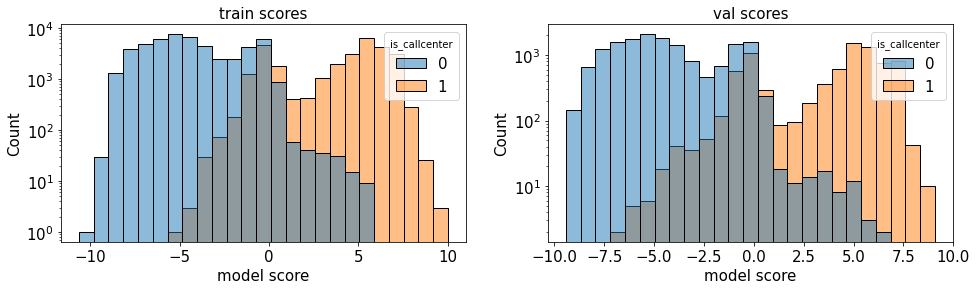

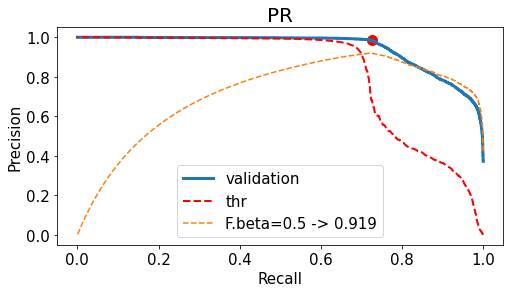

In [13]:
from seminar_utils import custom_fbeta
from sklearn.metrics import precision_recall_curve

params = dict()
params.update(init_params)

early_stopping_kwargs = dict()
early_stopping_kwargs.update(model_kwargs)
early_stopping_kwargs['callbacks'] = [lgb.log_evaluation(period=20), lgb.early_stopping(100)]
early_stopping_kwargs['num_boost_round'] = 300

model = lgb.train(
    params,
    feval=partial(custom_fbeta, beta=0.5, is_custom_objective=True),
    fobj=custom_log_loss_grad_hess, # <---
    **early_stopping_kwargs,
)

look_at_scores(model, raw=True, info=False)

from seminar_utils import plot_pr

y_prob = expit(model.predict(X_val[features]))

plot_pr(X_val.is_callcenter, y_prob, label='validation', beta=0.5)

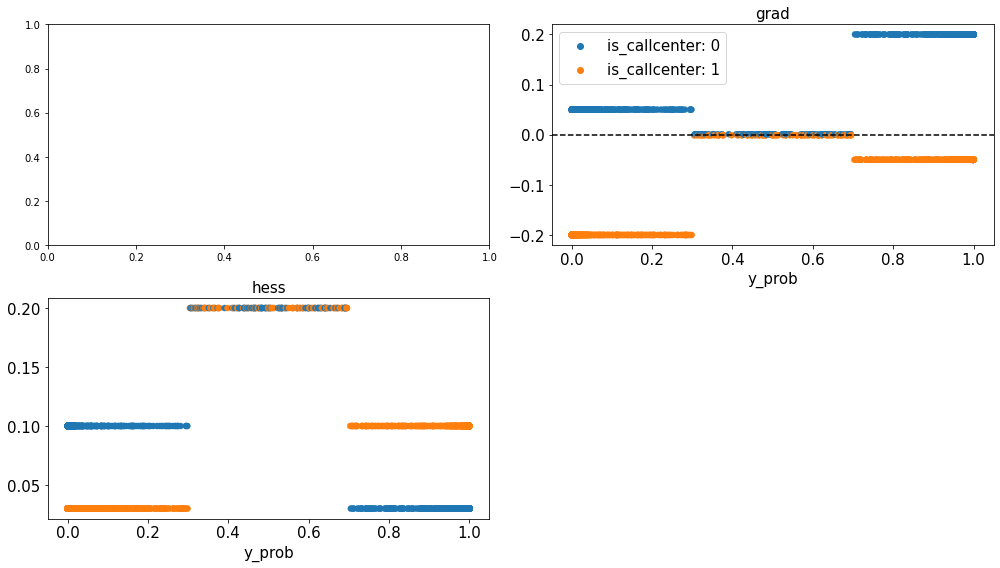

In [14]:
from seminar_utils import custom_new_grad_hess

plot_loss_grad_hess(fobj=custom_new_grad_hess)

In [ ]:
L(y_t-1 + w) ~ L(yt-1) + w * gi + 1/2 hi * w ** 2

[20]	train's fbeta: 0.918028	val's fbeta: 0.917685
[40]	train's fbeta: 0.918701	val's fbeta: 0.917542
[60]	train's fbeta: 0.918591	val's fbeta: 0.917594
[80]	train's fbeta: 0.918395	val's fbeta: 0.917521
[100]	train's fbeta: 0.918257	val's fbeta: 0.917521
[120]	train's fbeta: 0.918109	val's fbeta: 0.917521
[140]	train's fbeta: 0.918035	val's fbeta: 0.917525
init prediction range: -0.9384011069111017 2.0629849427134626

ROC AUC on val: 0.9597


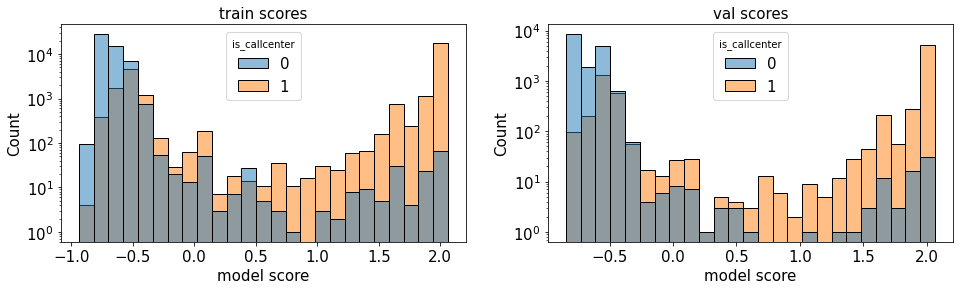

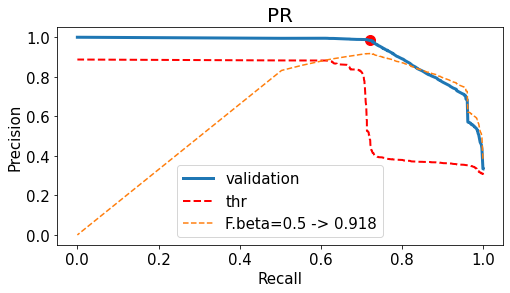

In [31]:
params = dict()
params.update(init_params)
params.update({
    'eta': 0.03
})

early_stopping_kwargs['callbacks'] = [lgb.log_evaluation(period=20), lgb.early_stopping(100)]

model = lgb.train(
    params,
    feval=partial(custom_fbeta, beta=0.5, is_custom_objective=True),
    fobj=custom_new_grad_hess, # <---
    **model_kwargs,
)

look_at_scores(model, raw=True, info=True)

from seminar_utils import plot_pr

y_prob = expit(model.predict(X_val[features]))

plot_pr(X_val.is_callcenter, y_prob, label='validation', beta=0.5)

***На что смотреть при конструировании своего лосса?***


$$ w_i  = - \frac{\sum g_{A_i} + \sum g_{B_i}}{\sum h_{A_i} + \sum h_{B_i} + \lambda} $$

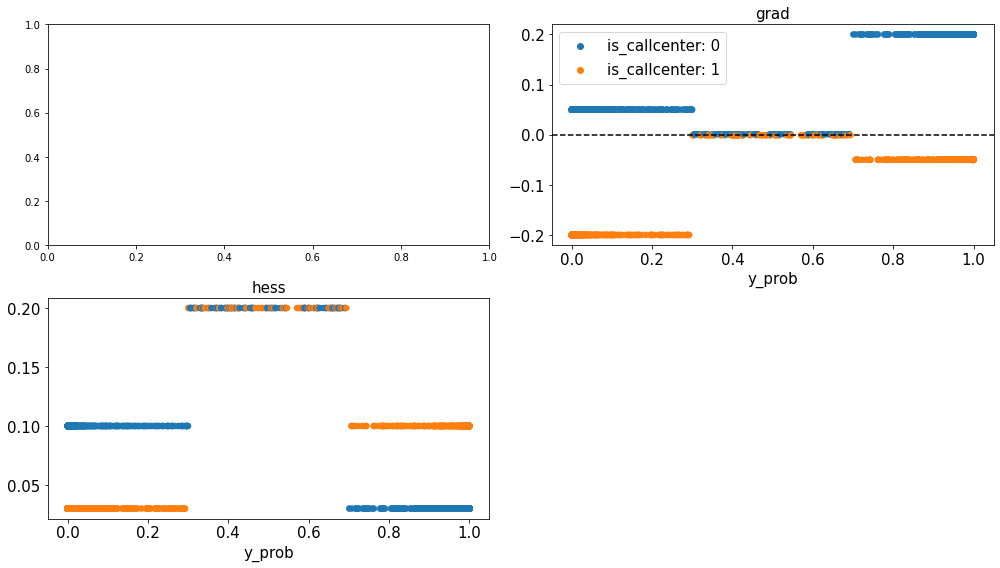

In [21]:
plot_loss_grad_hess(fobj=custom_new_grad_hess)

In [32]:
t = model.trees_to_dataframe()
t.query('node_depth < 2').head(10)

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S1,0-S3,None,pages_missing,18232.400391,2.5,<=,left,NaN,0.0,0.0,80539
61,1,1,1-S0,1-S1,1-S3,None,pages_missing,18232.400391,2.5,<=,left,NaN,0.0,0.0,80539
122,2,1,2-S0,2-S1,2-S3,None,pages_missing,18232.400391,2.5,<=,left,NaN,0.0,0.0,80539
183,3,1,3-S0,3-S2,3-S1,None,pages_missing,15491.599609,2.5,<=,left,NaN,0.0,0.0,80539
244,4,1,4-S0,4-S2,4-S1,None,last_date_diff,3909.429932,2038.5,<=,left,NaN,0.0,0.0,80539
305,5,1,5-S0,5-S1,5-S2,None,last_date_diff,3179.209961,2417.5,<=,left,NaN,0.0,0.0,80539
366,6,1,6-S0,6-S2,6-S1,None,last_date_diff,1841.650024,3193.5,<=,right,NaN,0.0,0.0,80539
427,7,1,7-S0,7-S2,7-S1,None,last_date_diff,1416.829956,2225.5,<=,right,NaN,0.0,0.0,80539
488,8,1,8-S0,8-S2,8-S1,None,last_date_diff,1200.939941,2225.5,<=,right,NaN,0.0,0.0,80539
549,9,1,9-S0,9-S1,9-S2,None,last_date_diff,459.666992,2038.5,<=,right,NaN,0.0,0.0,80539
